In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [2]:
#### Load true and false flares data
# Load dataframes
true_flares_df = pd.read_csv('../Chandra_data/trueflares.csv')
false_flares_df = pd.read_csv('../Chandra_data/falseflares.csv')
true_flares_df = true_flares_df[['time','energy','obsreg_id']]
false_flares_df = false_flares_df[['time','energy','obsreg_id']]

# Convert to data dictionary
d = true_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict()
d.update(false_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict())

In [3]:
# Prepare for data, drop the outliers
data_lst = []
lengths = []
Ts = []
length_threshold = 5000
T_threshold = 250000
t_scale = 5000
for key in list(d.keys()):
    length = len(d[key])
    T = max(d[key][:,0]) - min(d[key][:,0])
    if length > length_threshold or T > T_threshold:
        continue
    else:
        lengths.append(length)
        Ts.append(T)
        data_lst.append({'event_list':d[key]})

B = 16
data = RealEventsDataset(data_lst,t_scale=t_scale)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)
lengths = np.array(lengths)
Ts = np.array(Ts)

In [4]:
# # Visualization
# fig, ax = plt.subplots(1,2)
# ax[0].hist(lengths,bins=20);
# ax[0].set_title('Event list lengths')

# ax[1].hist(Ts,bins=20);
# ax[1].set_title('Event list time range')
# plt.tight_layout()

In [5]:
# Create NN model
num_freqs = 12
num_latent = 30
E_bins = 13
num_epochs = 400
encoding = PositionalEncoding(num_freqs=num_freqs)
model = AutoDecoder(num_latent, encoding, hidden_size=512, E_bins=E_bins, lam_TV=0.25, lam_latent=0)
trainer = pl.Trainer(max_epochs=num_epochs, 
                     accelerator=device, 
                     devices=1, 
                     plugins=[DisabledSLURMEnvironment(auto_requeue=False)], 
                     log_every_n_steps=2)
history = trainer.fit(model, loader)
torch.save(model.state_dict(), '../models/model_decoder1.pth')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /nobackup/users/yankeson/Astronomy/ppae/lightning_logs/version_373337/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | code    | PositionalEncoding | 0     
1 | decoder | ResnetFC           | 2.7 M 
-----------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.761    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 00210: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00276: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00317: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00358: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00399: reducing learning rate of group 0 to 1.5625e-05.


`Trainer.fit` stopped: `max_epochs=400` reached.


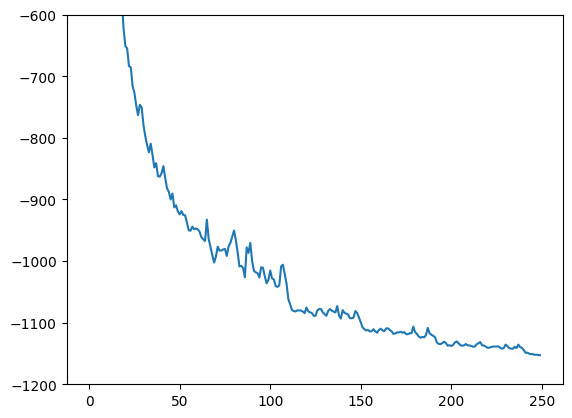

In [6]:
plt.plot(torch.arange(num_epochs), [l.cpu().detach() for l in model.losses])
plt.ylim([-1200,-600]);

In [7]:
# Test data, currently just the training data
model.load_state_dict(torch.load('../models/model_decoder1.pth'))
model.to(device)
test_loader = DataLoader(data, batch_size=B, collate_fn=padding_collate_fn)
outputs = []
for idx, batch in enumerate(test_loader):
    batch = todevice(batch, device)
    outputs.append(todevice(model(batch),'cpu'))

In [27]:
# def output_collate_fn(outputs):
#     '''
#     Outputs is a list of dic
#     '''
#     output = {}
#     for key in outputs[0].keys():
#         if key in ['latent','T','num_events']:
#             output[key] = torch.cat([o[key] for o in outputs], dim=0)
#         else:
#             output[key] = [o[key] for o in outputs]
#     return output

# collated_outputs = output_collate_fn(outputs)
# collated_outputs['num_events_per'] = collated_outputs['num_events'] / collated_outputs['T']

# metric = 'num_events'

# ##### PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# z = collated_outputs['latent'].detach().cpu().numpy()
# embedding = pca.fit_transform(z)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
#             marker='o',s=3, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
# plt.colorbar(scatter, label=metric)

# plt.xlabel('PCA component 1')
# plt.ylabel('PCA component 2')
# plt.legend(loc='best')
# plt.title('PCA of latent representations')
# plt.show()

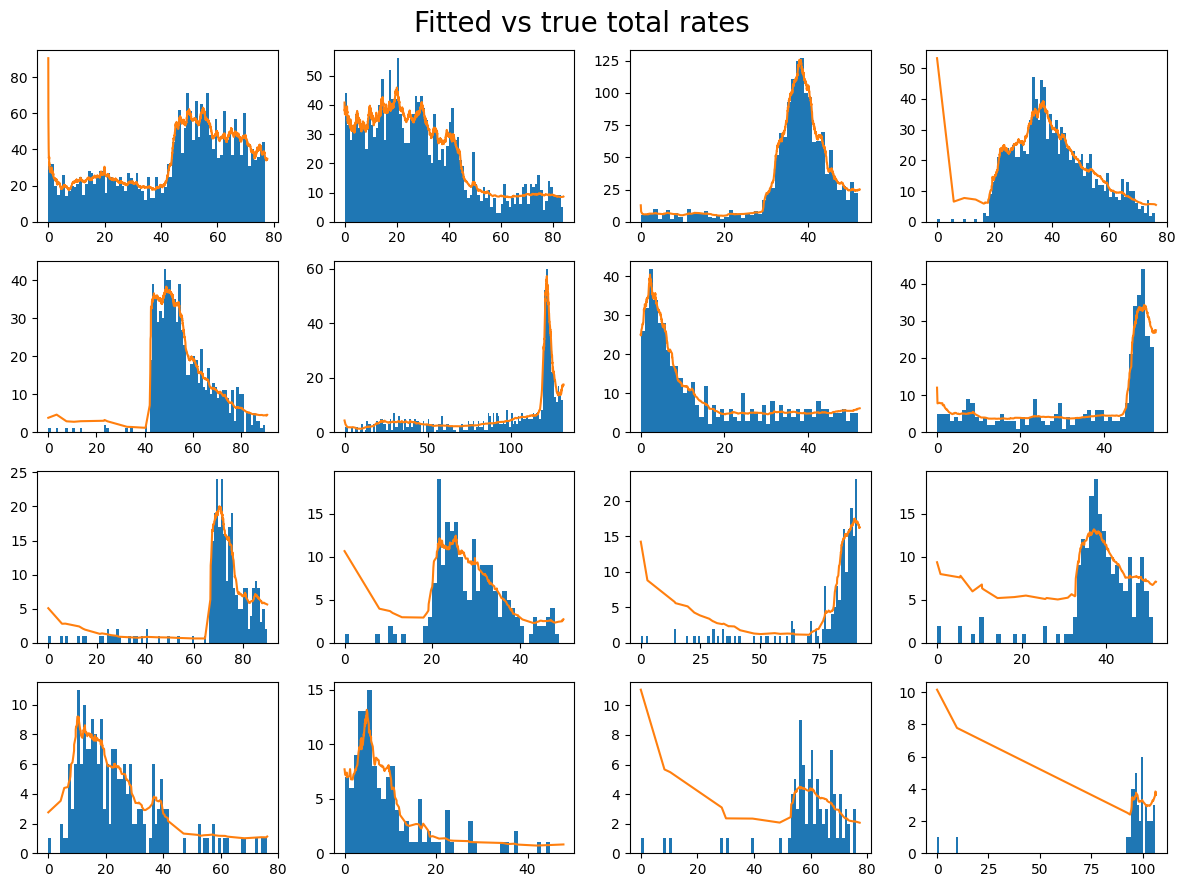

In [8]:
plotting_t_scale = 10

# Plot total rates
plt.figure(figsize=(12,9))
batch_index = 1
start_index = 0
for i in range(16):
    index = start_index + i
    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,0] * plotting_t_scale
    rates = batch['rates'][index,mask] / plotting_t_scale
    T = batch['T'][index] * plotting_t_scale
    plt.subplot(4,4,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(T)))
    plt.plot(times, torch.sum(rates,dim=-1))
    # plt.xlabel('t (rescaled for better visualization)')
    # plt.ylabel('rate')
plt.suptitle('Fitted vs true total rates',size=20)
plt.tight_layout()
plt.savefig('../plots/total_rate_comparison_decoder.png')
plt.show()




In [10]:
rates

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, n

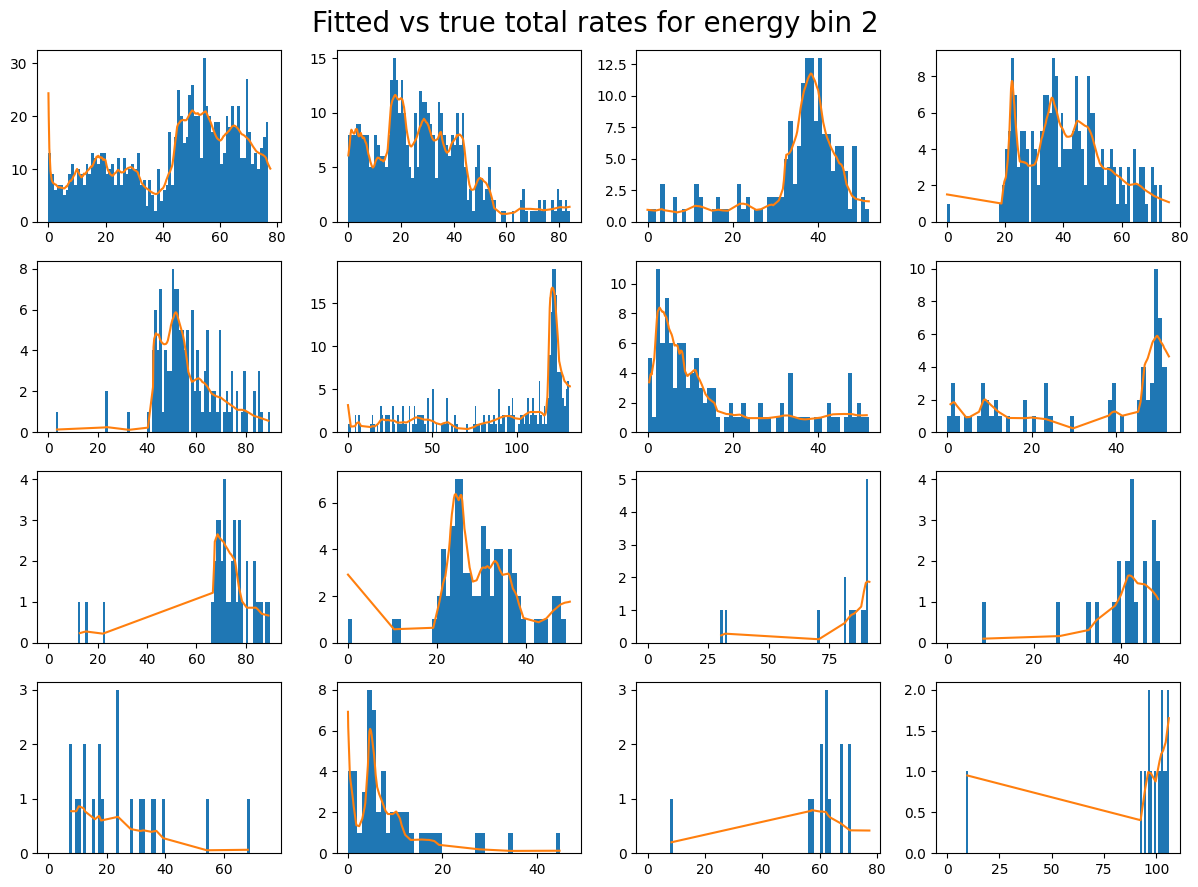

In [35]:
# Plot rates for a specific energy bin
plt.figure(figsize=(12,9))
batch_index = 1
start_index = 0
E_index = 1
for i in range(16):
    index = start_index + i
    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,:]
    E_mask = times[:,E_index+1]==1
    times = times[E_mask,0] * plotting_t_scale
    rates = batch['rates'][index,mask,E_index]
    rates = rates[E_mask] / plotting_t_scale
    T = batch['T'][index] * plotting_t_scale
    
    plt.subplot(4,4,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(T)))
    plt.plot(times, rates)
plt.suptitle(f'Fitted vs true total rates for energy bin {E_index+1}',size=20)
plt.tight_layout()
plt.savefig(f'../plots/total_rate_comparison_E{E_index+1}_decoder.png')
plt.show()